In [1]:
source = "Scenario8/development_dataset"

In [2]:
# Import modules and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

%matplotlib inline

/home/csci8523/ganta016/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
import tensorflow as tf

In [4]:
import re
csv_path = source+'/scenario8_dev_train_com.csv'
dataset_train = pd.read_csv(csv_path)

dataset_train = dataset_train.sort_values(by=['unit1_rgb_1'], key=lambda col: col.map(lambda x: int(re.split('_',x)[3])))
#print(dataset_train)

rgb_data = dataset_train[['unit1_rgb_1', 'beam_index_1']]
csv_path = source+'/scenario8_dev_val_com.csv'
dataset_val = pd.read_csv(csv_path)

dataset_val = dataset_val.sort_values(by=['unit1_rgb_1'], key=lambda col: col.map(lambda x: int(re.split('_',x)[3])))
#print(dataset_train)

In [5]:
from yolov4.tf import YOLOv4
yolo = YOLOv4()

yolo.config.parse_names("coco.names")
yolo.config.parse_cfg("yolov4-tiny.cfg")

yolo.make_model()
yolo.load_weights("yolov4-tiny.weights", weights_type="yolo")
yolo.summary(summary_type="yolo")
yolo.summary()

batch: 32
index layer No. filters  size/strd(dil)   input_shape         output_shape    1e9 flops
   0  convo_0      32      3 x 3 / 2      416 x 416 x   3 ->  208 x 208 x  32   0.075
   1  convo_1      64      3 x 3 / 2      208 x 208 x  32 ->  104 x 104 x  64   0.399
   2  convo_2      64      3 x 3 / 1      104 x 104 x  64 ->  104 x 104 x  64   0.797
   3  route_0       2,                                    ->  104 x 104 x  32
   4  convo_3      32      3 x 3 / 1      104 x 104 x  32 ->  104 x 104 x  32   0.199
   5  convo_4      32      3 x 3 / 1      104 x 104 x  32 ->  104 x 104 x  32   0.199
   6  route_1       5,  4,                                ->  104 x 104 x  64
   7  convo_5      64      1 x 1 / 1      104 x 104 x  64 ->  104 x 104 x  64   0.089
   8  route_2       2,  7,                                ->  104 x 104 x 128
   9  maxpo_0              2 x 2 / 2      104 x 104 x 128 ->   52 x  52 x 128   0.001
  10  convo_6     128      3 x 3 / 1       52 x  52 x 128 ->   52 

In [6]:
#from keras.backend import one_hot
import cv2
train_data = []
image_data = []
beam_data = []
#print(dataset_train['unit1_rgb_1'])
for j in dataset_train.index:
  #print(dataset_train['unit1_rgb_1'][j])
  img = cv2.imread(source+'/'+dataset_train['unit1_rgb_1'][j])
  #print(dataset_train['unit1_rgb_1'][j])
  #plt.imshow(img)
  #plt.show()
  y = yolo.predict(img, 0.25)
  y = y[0]
  y = y[:-2]
  #y = np.pad(y, (30, 30), 'constant', constant_values =(0, 0))
  #img = cv2.resize(img,(128,128))
  #img = img/255.0
  data = []
  data.append(y)
  one_hot = [0]*64
  one_hot[int(dataset_train['beam_index_1'][j])] = 1
  data.append(np.asarray(one_hot))
  train_data.append(data)
#train_data = train_data.astype(float)

#train_data = np.array(train_data, dtype = object)

# # Using multiple features (predictors)
# training_set = dataset_train.as_matrix()

#print('Shape of training set == {}.'.format(train_data.shape))
# training_set

In [7]:
#from keras.backend import one_hot
import cv2
val_data = []
image_data = []
beam_data = []
for j in dataset_val.index:
  #print(dataset_train['unit1_rgb_1'][j])
  img = cv2.imread(source+'/'+dataset_val['unit1_rgb_1'][j])
  #plt.imshow(img)
  #plt.show()
  y = yolo.predict(img, 0.25)
  y = y[0]
  y = y[:-2]
  #y = np.pad(y, (30, 30), 'constant', constant_values =(0, 0))
  #img = cv2.resize(img,(128,128))
  #img = img/255.0
  data = []
  data.append(y)
  one_hot = [0]*64
  one_hot[int(dataset_val['beam_index_1'][j])] = 1
  data.append(np.asarray(one_hot))
  val_data.append(data)
#train_data = train_data.astype(float)

#train_data = np.array(train_data, dtype = object)

# # Using multiple features (predictors)
# training_set = dataset_train.as_matrix()

#print('Shape of training set == {}.'.format(train_data.shape))
# training_set

In [8]:
#print(train_data[0][0].shape)
import tensorflow as tf
X_train = []
y_train = []

n_future = 3
n_past = 8

for i in range(n_past, len(train_data) - n_future+1):
  xtrain = []
  ytrain = []
  for j in range(i-n_past, i):
    x = []
    x.extend(train_data[j][0])
    x.extend(train_data[j][1])
    #x[1] = train_data[j][1]
    xtrain.append(x)
  X_train.append(xtrain)
  for j in range(i, i+n_future):
    ytrain.append(train_data[j][1])
  y_train.append(ytrain)

X_train, y_train = np.asarray(X_train), np.asarray(y_train)
print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (2821, 8, 68).
y_train shape == (2821, 3, 64).


In [9]:
#print(train_data[0][0].shape)
import tensorflow as tf
X_val = []
y_val = []

n_future = 3
n_past = 8

for i in range(n_past, len(val_data) - n_future+1):
  xtrain = []
  ytrain = []
  for j in range(i-n_past, i):
    x = []
    x.extend(val_data[j][0])
    x.extend(val_data[j][1])
    xtrain.append(x)
  X_val.append(xtrain)
  for j in range(i, i+n_future):
    ytrain.append(val_data[j][1])
  y_val.append(ytrain)

X_val, y_val = np.asarray(X_val), np.asarray(y_val)
print('X_val shape == {}.'.format(X_val.shape))
print('y_val shape == {}.'.format(y_val.shape))

X_val shape == (765, 8, 68).
y_val shape == (765, 3, 64).


In [10]:

from keras.models import Model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.layers import Input

inputs = Input(shape=(8,68)) # 7 past steps and variables
m = LSTM(64,  return_sequences=False)(inputs)
outputA = Dense(64, activation='softmax')(m)
outputB = Dense(64, activation='softmax')(m)
outputC = Dense(64, activation = 'softmax')(m)

model = Model(inputs=[inputs], outputs=[outputA, outputB, outputC])
model.compile(optimizer = Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics = ['accuracy'])

history = model.fit(X_train, [y_train[:,0], y_train[:,1], y_train[:,2]], epochs=250, validation_data=(X_val, [y_val[:,0], y_val[:,1], y_val[:,2]]), verbose=1, batch_size=16)

# model.add(conv2D(64,(5,5),padding = 'same',activation='relu'))

Epoch 1/250
177/177 [==============================] - 3s 9ms/step - loss: 12.3157 - dense_loss: 4.1086 - dense_1_loss: 4.0863 - dense_2_loss: 4.1208 - dense_accuracy: 0.0713 - dense_1_accuracy: 0.1042 - dense_2_accuracy: 0.0525 - val_loss: 12.1107 - val_dense_loss: 4.0417 - val_dense_1_loss: 4.0172 - val_dense_2_loss: 4.0518 - val_dense_accuracy: 0.1529 - val_dense_1_accuracy: 0.1608 - val_dense_2_accuracy: 0.1438
Epoch 2/250
177/177 [==============================] - 1s 6ms/step - loss: 11.3332 - dense_loss: 3.7909 - dense_1_loss: 3.7350 - dense_2_loss: 3.8073 - dense_accuracy: 0.1546 - dense_1_accuracy: 0.1507 - dense_2_accuracy: 0.1443 - val_loss: 10.6230 - val_dense_loss: 3.5543 - val_dense_1_loss: 3.5268 - val_dense_2_loss: 3.5419 - val_dense_accuracy: 0.1373 - val_dense_1_accuracy: 0.1386 - val_dense_2_accuracy: 0.1346
Epoch 3/250
177/177 [==============================] - 1s 6ms/step - loss: 10.0031 - dense_loss: 3.3636 - dense_1_loss: 3.2967 - dense_2_loss: 3.3428 - dense_accu

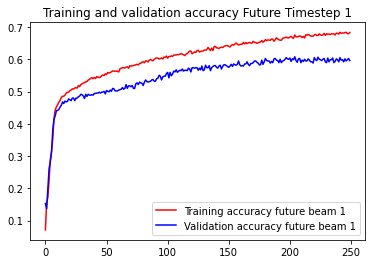

<Figure size 432x288 with 0 Axes>

In [11]:
import matplotlib.pyplot as plt

acc_1 = history.history['dense_accuracy']
val_acc_1 = history.history['val_dense_accuracy']
loss_1 = history.history['dense_loss']
val_loss_1 = history.history['val_dense_loss']
acc_2 = history.history['dense_1_accuracy']
val_acc_2 = history.history['val_dense_1_accuracy']
loss_2 = history.history['dense_1_loss']
val_loss_2 = history.history['val_dense_1_loss']
acc_3 = history.history['dense_2_accuracy']
val_acc_3 = history.history['val_dense_2_accuracy']
loss_3 = history.history['dense_2_loss']
val_loss_3 = history.history['val_dense_2_loss']
epochs = range(len(acc_1))

plt.plot(epochs, acc_1, 'r', label='Training accuracy future beam 1')
plt.plot(epochs, val_acc_1, 'b', label='Validation accuracy future beam 1')
plt.title('Training and validation accuracy Future Timestep 1')
plt.legend(loc=0)
plt.figure()


plt.show()

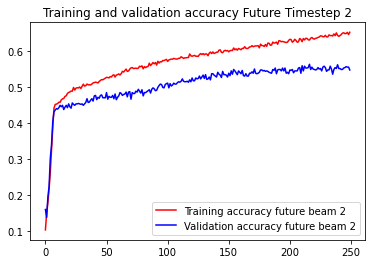

<Figure size 432x288 with 0 Axes>

In [12]:
plt.plot(epochs, acc_2, 'r', label='Training accuracy future beam 2')
plt.plot(epochs, val_acc_2, 'b', label='Validation accuracy future beam 2')
plt.title('Training and validation accuracy Future Timestep 2')
plt.legend(loc=0)
plt.figure()


plt.show()

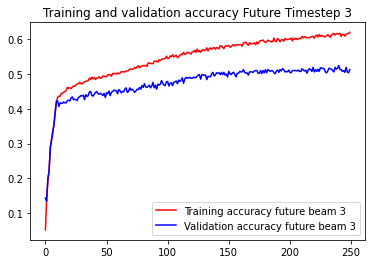

<Figure size 432x288 with 0 Axes>

In [13]:
plt.plot(epochs, acc_3, 'r', label='Training accuracy future beam 3')
plt.plot(epochs, val_acc_3, 'b', label='Validation accuracy future beam 3')
plt.title('Training and validation accuracy Future Timestep 3')
plt.legend(loc=0)
plt.figure()


plt.show()

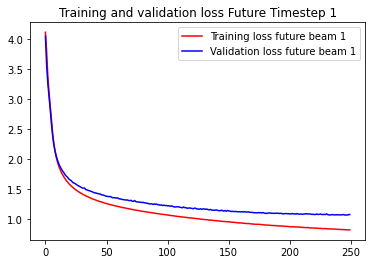

<Figure size 432x288 with 0 Axes>

In [14]:
plt.plot(epochs, loss_1, 'r', label='Training loss future beam 1')
plt.plot(epochs, val_loss_1, 'b', label='Validation loss future beam 1')
plt.title('Training and validation loss Future Timestep 1')
plt.legend(loc=0)
plt.figure()


plt.show()

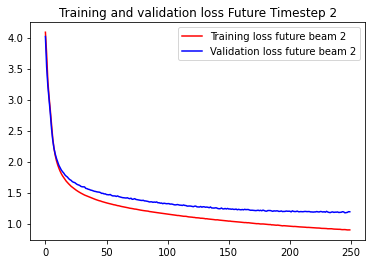

<Figure size 432x288 with 0 Axes>

In [15]:
plt.plot(epochs, loss_2, 'r', label='Training loss future beam 2')
plt.plot(epochs, val_loss_2, 'b', label='Validation loss future beam 2')
plt.title('Training and validation loss Future Timestep 2')
plt.legend(loc=0)
plt.figure()


plt.show()

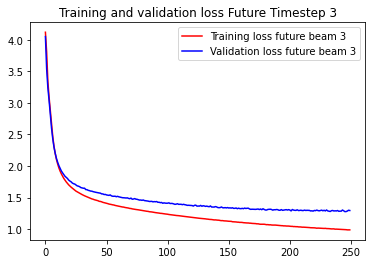

<Figure size 432x288 with 0 Axes>

In [16]:
plt.plot(epochs, loss_3, 'r', label='Training loss future beam 3')
plt.plot(epochs, val_loss_3, 'b', label='Validation loss future beam 3')
plt.title('Training and validation loss Future Timestep 3')
plt.legend(loc=0)
plt.figure()


plt.show()

In [17]:
model.save_weights('model_rgb_final3.h5')

In [18]:
csv_path = source+'/scenario8_dev_test_com.csv'
dataset_test = pd.read_csv(csv_path)

dataset_test = dataset_test.sort_values(by=['unit1_rgb_1'], key=lambda col: col.map(lambda x: int(re.split('_',x)[3])))
#print(dataset_train)

rgb_data = dataset_test[['unit1_rgb_1', 'beam_index_1']]
test_data = []
image_data = []
beam_data = []
for j in dataset_test.index:
  #print(dataset_train['unit1_rgb_1'][j])
  img = cv2.imread(source+'/'+dataset_test['unit1_rgb_1'][j])
  #plt.imshow(img)
  #plt.show()
  y = yolo.predict(img, 0.25)
  y = y[0]
  y = y[:-2]
  data = []
  data.append(y)
  one_hot = [0]*64
  one_hot[int(dataset_test['beam_index_1'][j])] = 1
  data.append(np.asarray(one_hot))
  test_data.append(data)
#print(test_data)
X_test = []
y_test = []
n_future = 3
n_past = 8

for i in range(n_past, len(test_data) - n_future+1):
  xtrain = []
  ytrain = []
  for j in range(i-n_past, i):
    x = []
    x.extend(test_data[j][0])
    x.extend(test_data[j][1])
    xtrain.append(x)
  X_test.append(xtrain)
  for j in range(i, i+n_future):
    ytrain.append(np.nonzero(test_data[j][1])[0][0])
    #print(np.nonzero(test_data[j][1])[0][0])
  y_test.append(np.asarray(ytrain))

X_test = np.asarray(X_test)
y_test = np.asarray(y_test)
print('X_train shape == {}.'.format(X_test.shape))

X_train shape == (427, 8, 68).


In [19]:
test_predictions_beam1 = []
test_predictions_beam2 = []
test_predictions_beam3 = []

for i in range(0,len(X_test)):
    pred1 = model.predict(X_test[i].reshape((1, 8, 68)))
    #print(pred1)
    test_predictions_beam1.append(pred1[0][0])
    test_predictions_beam2.append(pred1[1][0])
    test_predictions_beam3.append(pred1[2][0])
#print(test_predictions)

1/1 [==============================] - 0s 15ms/step


In [20]:
#print(test_predictions)
y_pred_beam1 = np.argmax(test_predictions_beam1, axis=-1)
y_pred_beam2 = np.argmax(test_predictions_beam2, axis=-1)
y_pred_beam3 = np.argmax(test_predictions_beam3, axis=-1)


In [21]:
from sklearn.metrics import accuracy_score, classification_report
#y_test = np.nonzero(y_test)[1]
accuracy_beam1 = accuracy_score(y_test[:, 0], y_pred_beam1)
accuracy_beam2 = accuracy_score(y_test[:, 1], y_pred_beam2)
accuracy_beam3 = accuracy_score(y_test[:, 2], y_pred_beam3)
print(accuracy_beam1)
print(accuracy_beam2)
print(accuracy_beam3)

0.6065573770491803
0.5690866510538641
0.5456674473067916


In [22]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import top_k_accuracy_score
#y_test = np.nonzero(y_test)[1]
top1_acc_beam1 = top_k_accuracy_score(y_test[:, 0], test_predictions_beam1, k=1, labels=range(64))
top1_acc_beam2 = top_k_accuracy_score(y_test[:, 1], test_predictions_beam2, k=1, labels=range(64))
top1_acc_beam3 = top_k_accuracy_score(y_test[:, 2], test_predictions_beam3, k=1, labels=range(64))

top2_acc_beam1 = top_k_accuracy_score(y_test[:, 0], test_predictions_beam1, k=2, labels=range(64))
top2_acc_beam2 = top_k_accuracy_score(y_test[:, 1], test_predictions_beam2, k=2, labels=range(64))
top2_acc_beam3 = top_k_accuracy_score(y_test[:, 2], test_predictions_beam3, k=2, labels=range(64))

top3_acc_beam1 = top_k_accuracy_score(y_test[:, 0], test_predictions_beam1, k=3, labels=range(64))
top3_acc_beam2 = top_k_accuracy_score(y_test[:, 1], test_predictions_beam2, k=3, labels=range(64))
top3_acc_beam3 = top_k_accuracy_score(y_test[:, 2], test_predictions_beam3, k=3, labels=range(64))

print("Top1 Future beam at timestep 1: ", top1_acc_beam1)
print("Top1 Future beam at timestep 2: ", top1_acc_beam2)
print("Top1 Future beam at timestep 3: ", top1_acc_beam3)

print("Top2 Future beam at timestep 1: ", top2_acc_beam1)
print("Top2 Future beam at timestep 2: ", top2_acc_beam2)
print("Top2 Future beam at timestep 3: ", top2_acc_beam3)

print("Top3 Future beam at timestep 1: ", top3_acc_beam1)
print("Top3 Future beam at timestep 2: ", top3_acc_beam2)
print("Top3 Future beam at timestep 3: ", top3_acc_beam3)


Top1 Future beam at timestep 1:  0.6065573770491803
Top1 Future beam at timestep 2:  0.5690866510538641
Top1 Future beam at timestep 3:  0.5456674473067916
Top2 Future beam at timestep 1:  0.8548009367681498
Top2 Future beam at timestep 2:  0.8266978922716628
Top2 Future beam at timestep 3:  0.7798594847775175
Top3 Future beam at timestep 1:  0.9250585480093677
Top3 Future beam at timestep 2:  0.9156908665105387
Top3 Future beam at timestep 3:  0.9086651053864169
